In [3]:
import pandas as pd
import numpy as np
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from umap.umap_ import UMAP
from hdbscan import HDBSCAN
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sentence_transformers import SentenceTransformer
import numpy as np
import re
import json

In [10]:
# Chargement du fichier XLSX
file_path = "fichier_traduit.xlsx"
df = pd.read_excel(file_path, engine='openpyxl')

# Afficher les premières lignes pour vérifier
df.head()


id             nom  date_ouverture  date_fermeture                 website  \
0  71         La loge          2012.0             NaN          www.la-loge.be   
1   8  Jeune création          2006.0             NaN                     NaN   
2  72       The ister          2011.0             NaN         www.theister.be   
3  73         Komplot          2002.0             NaN            www.kmplt.be   
4  74         Abilene          2011.0             NaN  www.abilenegallery.com   

                        email                             adresse horaires  \
0             info@la-loge.be  Kluisstraat - rue de l’Ermitage 86      NaN   
1     jeunecreation@gmail.com                       24 rue Berthe      NaN   
2            info@theister.be                rue Vandenbranden 42      NaN   
3               info@kmplt.be           295 Avenue Van Volxemlaan      NaN   
4  contact@abilenegallery.com              Rue de la Victoire 163      NaN   

  presentation responsables  ... longitude  \
0          NaN          NaN  ...  4.365647   
1          NaN          NaN  ...  2.339779   
2          NaN          NaN  ...  4.340663   
3          NaN          NaN  ...  4.325936   
4          NaN          NaN  ...  4.352473   

                                    adresse_complete codepostal telephone  \
0  Kluisstraat - rue de l’Ermitage 86, 1050, Brux...     1050.0       NaN   
1                24 rue Berthe, 75018, Paris, France    75018.0       NaN   
2    rue Vandenbranden 42, 1000, Bruxelles, Belgique     1000.0       NaN   
3  295 Avenue Van Volxemlaan, 1190, Bruxelles, Be...     1190.0       NaN   
4  Rue de la Victoire 163, 1060, Bruxelles, Belgique     1060.0       NaN   

  visite user_id question1 réponse1 question2 réponse2  
0    NaN     NaN       NaN      NaN       NaN      NaN  
1    NaN     1.0       NaN      NaN       NaN      NaN  
2    NaN     NaN       NaN      NaN       NaN      NaN  
3    NaN     NaN       NaN      NaN       NaN      NaN  
4    NaN     NaN       NaN      NaN       NaN      NaN  

[5 rows x 40 columns]

In [12]:
df.columns 

Index(['id', 'nom', 'date_ouverture', 'date_fermeture', 'website', 'email',
       'adresse', 'horaires', 'presentation', 'responsables', 'historique',
       'activites', 'expositions', 'publications', 'events', 'residences',
       'workshop', 'archive', 'librairie', 'coworking', 'education',
       'nb_expos_an', 'nb_artistes_an', 'partenaires', 'created_at',
       'updated_at', 'slug', 'pays', 'ville', 'latitude', 'longitude',
       'adresse_complete', 'codepostal', 'telephone', 'visite', 'user_id',
       'question1', 'réponse1', 'question2', 'réponse2'],
      dtype='object')

In [5]:
def clean_text(text):
    if pd.isna(text):
        return ""
    
    # Convertir en string
    text = str(text)
    
    # Nettoyer les marqueurs de retour à la ligne spécifiques
    text = text.replace('_*x000d*_', ' ')
    
    # Nettoyer les espaces multiples
    text = ' '.join(text.split())
    
    return text.strip()

def load_and_prepare_data(df):
    processed_texts = []
    space_names = []
    text_types = []
    
    for idx, row in df.iterrows():
        for content_type in ['activites', 'presentation', 'historique', 'réponse1', 'réponse2']:
            content = row[content_type]
            if pd.notna(content) and str(content).strip() != "":
                # Nettoyer le texte
                cleaned_text = clean_text(content)
                
                # Vérifier si le texte n'est pas vide après nettoyage
                if cleaned_text:
                    processed_texts.append(cleaned_text)
                    space_names.append(str(row['nom']).strip())
                    text_types.append(content_type)
    
    # Créer le DataFrame
    processed_df = pd.DataFrame({
        'nom': space_names,
        'type_texte': text_types,
        'texte': processed_texts
    })
    
    # Afficher les statistiques
    print("Statistiques :")
    print(f"Nombre total de documents : {len(processed_df)}")
    print("\nRépartition par type de texte :")
    print(processed_df['type_texte'].value_counts())
    print("\nNombre d'espaces uniques :", len(processed_df['nom'].unique()))
    
    # Afficher quelques exemples pour vérification
    print("\nExemples de textes nettoyés :")
    for type_texte in processed_df['type_texte'].unique():
        print(f"\n{type_texte}:")
        print(processed_df[processed_df['type_texte'] == type_texte]['texte'].iloc[0][:200])
    
    return processed_df

# Préparer les données
processed_df = load_and_prepare_data(df)

Statistiques :
Nombre total de documents : 455

Répartition par type de texte :
type_texte
presentation    264
historique       94
activites        72
réponse2         13
réponse1         12
Name: count, dtype: int64

Nombre d'espaces uniques : 280

Exemples de textes nettoyés :

presentation:
The Commission is a production structure for contemporary art exhibitions founded in 2006. It is at the initiative of fifty exhibitions and events in France and abroad, it presents the works of emergi

historique:
The Commission was founded in 2006 by Fayçal Bagriche, Mathieu Clainchard, Dorothée Dupuis and Vincent Ganivet. From 2008 to 2011, independent exhibition Commissioner Damien Airault provided the lead.

activites:
All of the activities that we will develop and organize will have no budget and no lucrative aims: this will not be a limit but it will turn to our advantage in the goal of creating an environment of 

réponse1:
Immania was created in 1998 at a time when many artists appeared. 

In [14]:
# Le script doit être placé après processed_df = load_and_prepare_data(df)

def create_geo_json(df_original):
    """
    Crée le fichier JSON directement à partir du DataFrame original
    puisque c'est lui qui contient toutes les informations géographiques
    """
    # Créer une liste pour stocker les données géographiques
    geo_data = []
    
    # Statistiques
    total_spaces = len(df_original)
    spaces_without_coords = 0
    
    # Traiter chaque espace du DataFrame original
    for idx, space_info in df_original.iterrows():
        try:
            if pd.notna(space_info['latitude']) and pd.notna(space_info['longitude']):
                space_object = {
                    "nom": str(space_info['nom']).strip(),
                    "latitude": float(space_info['latitude']),
                    "longitude": float(space_info['longitude']),
                    "ville": str(space_info['ville']) if pd.notna(space_info['ville']) else "",
                    "pays": str(space_info['pays']) if pd.notna(space_info['pays']) else "",
                    "website": str(space_info['website']) if pd.notna(space_info['website']) else ""
                }
                geo_data.append(space_object)
            else:
                print(f"Avertissement: Coordonnées manquantes pour '{space_info['nom']}'")
                spaces_without_coords += 1
        except (ValueError, TypeError) as e:
            print(f"Erreur avec les coordonnées de '{space_info['nom']}': {e}")
            spaces_without_coords += 1
    
    # Afficher les statistiques
    print(f"\nStatistiques de géolocalisation:")
    print(f"Nombre total d'espaces: {total_spaces}")
    print(f"Espaces sans coordonnées valides: {spaces_without_coords}")
    print(f"Espaces avec coordonnées valides: {len(geo_data)}")
    
    # Afficher la répartition par pays
    if geo_data:
        pays_count = {}
        for space in geo_data:
            if space['pays']:  # Ne compter que si le pays est spécifié
                pays_count[space['pays']] = pays_count.get(space['pays'], 0) + 1
        print("\nRépartition par pays:")
        for pays, count in sorted(pays_count.items()):
            print(f"{pays}: {count} espaces")
    
    # Sauvegarder en JSON
    if geo_data:
        with open('data.json', 'w', encoding='utf-8') as f:
            json.dump(geo_data, f, ensure_ascii=False, indent=2)
        print(f"\nFichier JSON créé avec succès.")
        
        # Afficher quelques exemples
        print("\nExemples d'entrées du fichier JSON:")
        for entry in geo_data[:3]:
            print(json.dumps(entry, ensure_ascii=False, indent=2))
    else:
        print("\nAvertissement: Aucune donnée valide à sauvegarder")
    
    return geo_data

# Importer json si ce n'est pas déjà fait
import json

# Créer le fichier JSON directement à partir du DataFrame original
try:
    geo_data = create_geo_json(df)
except Exception as e:
    print(f"Erreur lors de la création du fichier JSON: {e}")
    import traceback
    traceback.print_exc()

Avertissement: Coordonnées manquantes pour 'PeepSpace'
Avertissement: Coordonnées manquantes pour 'Kurt-forever'
Avertissement: Coordonnées manquantes pour 'Palais des paris'
Avertissement: Coordonnées manquantes pour 'GLASSBOX-NORD'

Statistiques de géolocalisation:
Nombre total d'espaces: 336
Espaces sans coordonnées valides: 4
Espaces avec coordonnées valides: 332

Répartition par pays:
Albanie: 2 espaces
Allemagne: 39 espaces
Australia: 6 espaces
Austria: 2 espaces
Azerbaijan: 1 espaces
Belgique: 26 espaces
Bosnia And Herzegovina: 1 espaces
Brésil: 1 espaces
Bulgaria: 2 espaces
Canada: 30 espaces
Chile: 2 espaces
Chine: 3 espaces
Colombia: 1 espaces
Cyprus: 2 espaces
Danemark: 1 espaces
Egypt: 2 espaces
España: 6 espaces
France: 121 espaces
Georgia: 2 espaces
Grèce: 3 espaces
Hungary: 4 espaces
Inde: 1 espaces
Iran: 1 espaces
Ireland: 1 espaces
Italy: 14 espaces
Korea: 5 espaces
Maroc: 4 espaces
Netherlands: 11 espaces
Scotland: 3 espaces
Singapore: 1 espaces
Switzerland: 11 espace

2025-02-12 15:25:32,304 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/15 [00:00<?, ?it/s]

2025-02-12 15:25:34,588 - BERTopic - Embedding - Completed ✓
2025-02-12 15:25:34,589 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-02-12 15:25:35,399 - BERTopic - Dimensionality - Completed ✓
2025-02-12 15:25:35,402 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-12 15:25:35,476 - BERTopic - Cluster - Completed ✓
2025-02-12 15:25:35,476 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-02-12 15:25:35,618 - BERTopic - Representation - Completed ✓
2025-02-12 15:25:35,619 - BERTopic - Topic reduction - Reducing number of topics
2025-02-12 15:25:35,726 - BERTopic - Topic reduction - Reduced number of topics from 71 to 56


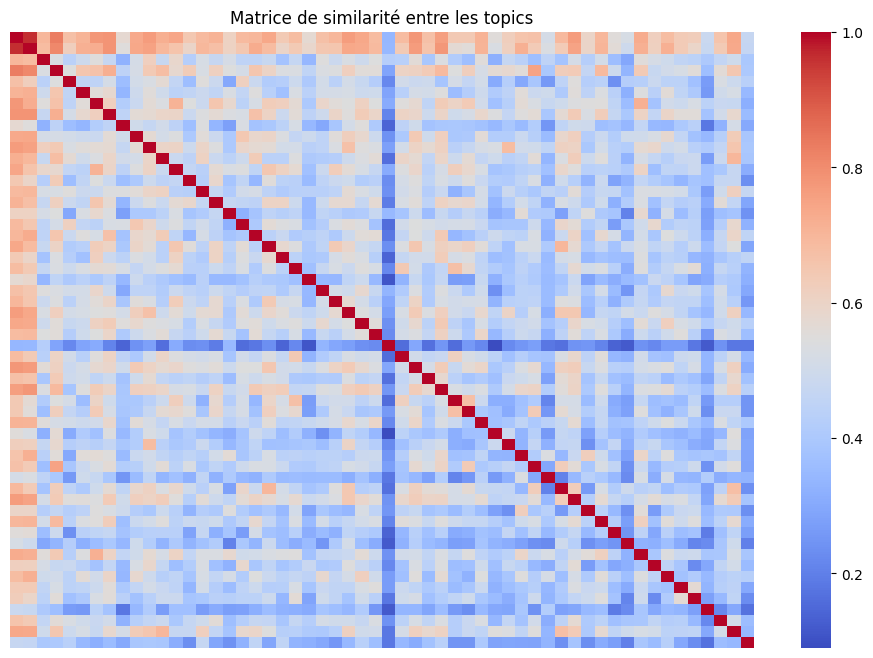


Topics à fusionner selon le seuil : {0: [1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 15, 19, 25, 26, 30, 32, 35, 42, 44, 47, 54], 1: [3, 5, 6, 7, 9, 10, 18, 25, 26, 30, 32, 35, 38, 42, 44, 47, 49, 54], 3: [7, 39], 6: [12, 47], 11: [54]}

Topics nettoyés :

Topic 0:
artists, contemporary, artist, exhibitions, projects

Topic 1:
self, production, self production, production self, wonder

Topic 2:
gallery, gallery 44, 44, clocktower, facilities

Topic 3:
michele, michele michele, deborah bowmann, deborah, bowmann

Topic 4:
west, front, west space, western front, western

Topic 5:
wall, wall wall, rooms, steps, district

Topic 6:
pool, artpool, loop, alternative, 2010

Topic 7:
carrega, poetry, ugo carrega, centro, ugo

Topic 8:
work work, work, mares, devices, admare

Topic 9:
matter, printed matter, printed, atelier, prints

Topic 10:
zona, nannucci, maurizio, maurizio nannucci, florence

Topic 11:
industrial, saint, wonder, this industrial, provision skills

Topic 12:
glassbox, sorbine, sncf, wro

In [14]:
# Section 3 : Configuration et Entraînement du Modèle
###########################################

def clean_word(word):
    # Nettoyer un mot individuel
    word = re.sub(r'x000D|x0002', '', word)
    word = word.replace('_', ' ')
    
    word = re.sub(r'\b(\w+)\b\s+\b\1\b', r'\1', word)  # Supprime les répétitions
    
    # Séparer les dates et les mots
    word = re.sub(r'(\d{4})([A-Za-z])', r'\1 \2', word)
    
    # Supprimer la ponctuation
    word = re.sub(r'[^\w\s]', ' ', word)
    
    # Nettoyer les espaces
    word = ' '.join(word.split())
    
    # Limiter la longueur à 2 mots maximum
    words = word.split()
    if len(words) > 2:
        words = words[:2]
    word = ' '.join(words)
    
    # Ne pas retourner de mots trop courts ou uniquement numériques
    if len(word) <= 2 or word.isdigit():
        return ""
        
    return word

def clean_topic_names(topic_model):
    cleaned_topics = {}
    for topic_id, topic_info in topic_model.get_topics().items():
        seen_words = set() 
        cleaned_words = []
        for word, score in topic_info:
            # 1. Remove irrelevant characters (more aggressive)
            word = re.sub(r'[^\w\s-]', '', word)  # Allow hyphens
            word = word.lower() 
            # 2. Remove single characters
            if len(word) > 1 and word not in seen_words: 
                cleaned_words.append((word, score))
                seen_words.add(word)
        cleaned_topics[topic_id] = cleaned_words[:5] 
    return cleaned_topics

def preprocess_text(text):
    # Nettoyer le texte
    text = re.sub(r'x000D|x0002', '', text)
    text = re.sub(r'_+', ' ', text)
    text = re.sub(r'(\d{4})([A-Za-z])', r'\1 \2', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    # Limiter la longueur des phrases
    words = text.split()
    phrases = [' '.join(words[i:i+2]) for i in range(0, len(words), 2)]
    
    return ' '.join(phrases).strip()

# Configuration des modèles
umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

hdbscan_model = HDBSCAN(
    min_cluster_size=3,
    min_samples=2,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

# Configuration du vectorizer avec nettoyage amélioré
vectorizer_model = CountVectorizer(
    stop_words=list(ENGLISH_STOP_WORDS) + ["art", "space", "project"],  # Ajouter des mots non discriminants
    ngram_range=(1, 2),  # Limiter à 2-grams max
    preprocessor=preprocess_text,
    max_features=5000  # Réduire le vocabulaire total pour éviter la dispersion
)


# Définir le modèle de phrase AVANT BERTopic
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Configuration et entraînement de BERTopic
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    min_topic_size=5,  # Augmenter la taille minimale des topics
    n_gram_range=(1, 2),  # Limiter la longueur des n-grammes
    nr_topics="auto",  # Laisser le modèle décider du nombre de topics
    calculate_probabilities=True,
    verbose=True
)

# Entraînement
topics, probs = topic_model.fit_transform(processed_df['texte'].tolist())

# Nettoyer les topics après l'entraînement
cleaned_topics = clean_topic_names(topic_model)

from sklearn.metrics.pairwise import cosine_similarity

# Vérifier si les embeddings de topics existent
if hasattr(topic_model, "topic_embeddings_") and topic_model.topic_embeddings_ is not None:
    # Obtenir les embeddings des topics
    topic_embeddings = topic_model.topic_embeddings_

    # Calculer la similarité cosinus entre topics
    topic_sim_matrix = cosine_similarity(topic_embeddings)

    # Afficher la heatmap des similarités entre topics

    plt.figure(figsize=(12, 8))
    sns.heatmap(topic_sim_matrix, cmap="coolwarm", xticklabels=False, yticklabels=False)
    plt.title("Matrice de similarité entre les topics")
    plt.show()
    
    # Déterminer les topics similaires à fusionner
    threshold = 0.7  # Seuil de similarité pour fusionner
    merged_topics = {}
    
    for i in range(len(topic_sim_matrix)):
        for j in range(i + 1, len(topic_sim_matrix)):
            if topic_sim_matrix[i, j] > threshold:
                merged_topics.setdefault(i, []).append(j)

    print("\nTopics à fusionner selon le seuil :", merged_topics)

    # Optionnel : Mettre à jour les topics fusionnés dans le DataFrame
    topic_mapping = {t: min(group) for group in merged_topics.values() for t in group}
    processed_df["topic"] = processed_df["topic"].replace(topic_mapping)

else:
    print("Les embeddings de topics ne sont pas disponibles dans le modèle.")



# Ajouter les résultats au DataFrame
processed_df['topic'] = topics

# Pour les probabilités
if isinstance(probs, np.ndarray):
    max_probs = np.max(probs, axis=1)
    processed_df['topic_probability'] = max_probs
else:
    processed_df['topic_probability'] = 1.0

# Afficher les topics nettoyés pour vérification
print("\nTopics nettoyés :")
for topic_id, words in cleaned_topics.items():
    if topic_id != -1:
        print(f"\nTopic {topic_id}:")
        print(", ".join([word for word, _ in words[:5]]))

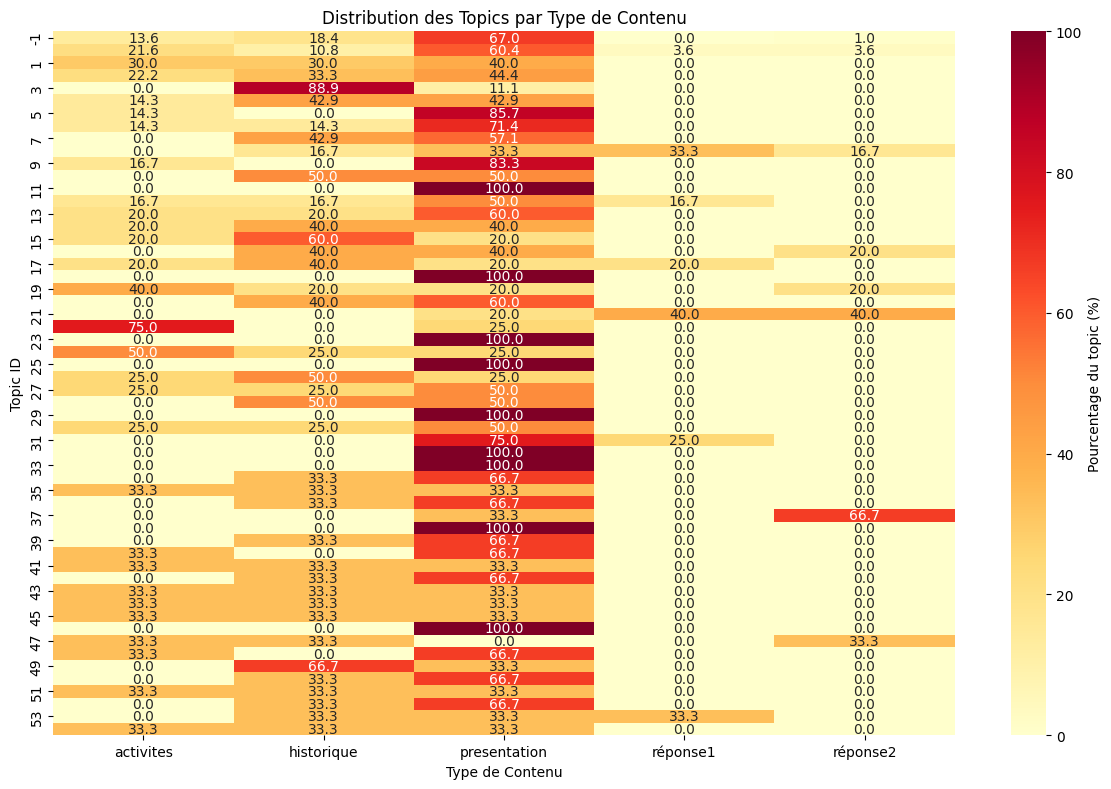


Analyse détaillée des topics :

Topic 0:
Mots-clés: artists, space, art, contemporary, artist
Distribution par type de contenu:
- presentation: 60.4%
- activites: 21.6%
- historique: 10.8%
- réponse2: 3.6%
- réponse1: 3.6%
Exemples de documents:

presentation:
TCB art inc. is a space run by artists based in Melbourne, Australia, dedicated to providing a space where young, emerging and established artists alike have the artistic freedom to explore, experimen...

historique:
Founded in 2011 by Aida Mahmudova, YARAT Contemporary Art Space is a non-commercial organisation dedicated to the promotion and nurturing of Contemporary art in Azerbaijan. Based in Baku, YARAT aims t...

activites:
All of the activities that we will develop and organize will have no budget and no lucrative aims: this will not be a limit but it will turn to our advantage in the goal of creating an environment of ...

réponse1:
A free programming space, based on the more or less successful meeting with works and arti

In [38]:

# 5. Analyse des relations entre topics et types de contenu
def analyze_topic_content_relationships(df):
    topic_content_matrix = pd.crosstab(df['topic'], df['type_texte'], normalize='index') * 100
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(topic_content_matrix, 
                annot=True, 
                fmt='.1f',
                cmap='YlOrRd',
                cbar_kws={'label': 'Pourcentage du topic (%)'})
    plt.title('Distribution des Topics par Type de Contenu')
    plt.ylabel('Topic ID')
    plt.xlabel('Type de Contenu')
    plt.tight_layout()
    plt.show()
    
    print("\nAnalyse détaillée des topics :")
    for topic in sorted(df['topic'].unique()):
        if topic != -1:
            print(f"\nTopic {topic}:")
            keywords = topic_model.get_topic(topic)
            print(f"Mots-clés: {', '.join([word for word, _ in keywords[:5]])}")
            
            topic_dist = df[df['topic'] == topic]['type_texte'].value_counts(normalize=True) * 100
            print("Distribution par type de contenu:")
            for content_type, percentage in topic_dist.items():
                print(f"- {content_type}: {percentage:.1f}%")
            
            print("Exemples de documents:")
            for content_type in df['type_texte'].unique():
                examples = df[(df['topic'] == topic) & (df['type_texte'] == content_type)]['texte'].head(1)
                if not examples.empty:
                    print(f"\n{content_type}:")
                    print(examples.iloc[0][:200] + "...")

def create_interactive_topic_mapping(df, topic_model):
    topic_data = []
    for topic in sorted(df['topic'].unique()):
        if topic != -1:
            keywords = topic_model.get_topic(topic)
            topic_docs = df[df['topic'] == topic]
            
            for content_type in df['type_texte'].unique():
                count = len(topic_docs[topic_docs['type_texte'] == content_type])
                if count > 0:
                    topic_data.append({
                        'Topic': f"Topic {topic}",
                        'Type_Contenu': content_type,
                        'Count': count,
                        'Keywords': ', '.join([word for word, _ in keywords[:3]])
                    })
    
    topic_df = pd.DataFrame(topic_data)
    
    fig = px.sunburst(
        topic_df,
        path=['Type_Contenu', 'Topic'],
        values='Count',
        hover_data=['Keywords'],
        width=800,
        height=800
    )
    
    fig.update_layout(title="Mapping des Topics aux Types de Contenu")
    fig.write_html("topic_content_mapping.html")
    return fig

# 6. Exécuter les analyses
analyze_topic_content_relationships(processed_df)
fig = create_interactive_topic_mapping(processed_df, topic_model)
fig.show()

# 7. Sauvegarder les résultats
detailed_analysis = pd.DataFrame({
    'topic': processed_df['topic'],
    'type_texte': processed_df['type_texte'],
    'texte': processed_df['texte']
}).groupby(['topic', 'type_texte']).agg({
    'texte': 'count'
}).unstack()

detailed_analysis.to_excel('topic_content_analysis.xlsx')

In [6]:
# Section 4 : Visualisations Interactives
###########################################
# 1. Intertopic Distance Map
topic_viz = topic_model.visualize_topics()
topic_viz.show()
topic_viz.write_html("intertopic_distance_map.html")

# 2. Document Map
doc_viz = topic_model.visualize_documents(processed_df['texte'])
doc_viz.show()
doc_viz.write_html("document_visualization.html")

# 3. Topic Hierarchy
hierarchy_viz = topic_model.visualize_hierarchy()
hierarchy_viz.show()
hierarchy_viz.write_html("topic_hierarchy.html")

# 4. Topic Distribution
barchart_viz = topic_model.visualize_barchart()
barchart_viz.show()
barchart_viz.write_html("topic_distribution.html")



Analyse pour presentation:
Topics dominants:
-1     69
 0     67
 5      6
 11     6
 6      5
Name: count, dtype: int64

Mots-clés des topics dominants:
Topic 0: [('artists', 0.015286607057612733), ('contemporary', 0.011119330858772055), ('artist', 0.010326746618006432), ('exhibitions', 0.010135324684033352), ('projects', 0.009978190249131528)]
Topic 5: [('wall', 0.11937416066918732), ('wall wall', 0.1160832597987696), ('rooms', 0.05968708033459366), ('STEPS', 0.04245275251377726), ('district', 0.03823976859129745)]
Topic 11: [('industrial', 0.043539111756610675), ('Saint', 0.04080114987071579), ('WONDER', 0.040345169055646474), ('This industrial', 0.040345169055646474), ('provision skills', 0.040345169055646474)]
Topic 6: [('pool', 0.09217095431112056), ('Artpool', 0.07418107623371928), ('Loop', 0.052462586215970074), ('alternative', 0.04569369720502268), ('2010', 0.034087047414272514)]

Analyse pour historique:
Topics dominants:
-1    19
 0    12
 3     8
 7     3
 2     3
Name: co

<Figure size 1500x800 with 0 Axes>

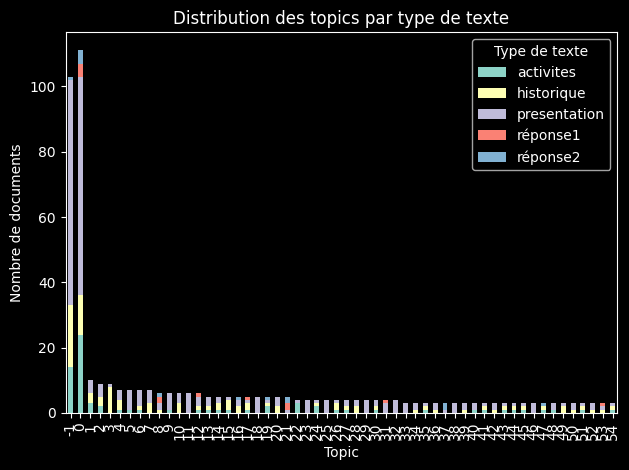

In [7]:
# Section 5 : Analyses par Type de Contenu
###########################################
# Analyse des topics par type
topics_series = pd.Series(topics, index=processed_df.index)

for content_type in processed_df['type_texte'].unique():
    print(f"\nAnalyse pour {content_type}:")
    mask = processed_df['type_texte'] == content_type
    subset_topics = topics_series[mask]
    
    print("Topics dominants:")
    print(subset_topics.value_counts().head())
    print("\nMots-clés des topics dominants:")
    for topic in subset_topics.value_counts().head().index:
        if topic != -1:
            keywords = topic_model.get_topic(topic)[:5]
            print(f"Topic {topic}: {keywords}")

# Visualisation de la distribution des topics par type
topic_by_type = pd.DataFrame({
    'type_texte': processed_df['type_texte'],
    'topic': topics
})
topic_counts = topic_by_type.groupby(['type_texte', 'topic']).size().reset_index(name='count')

plt.figure(figsize=(15, 8))
pivot_table = topic_counts.pivot(index='topic', columns='type_texte', values='count').fillna(0)
pivot_table.plot(kind='bar', stacked=True)
plt.title("Distribution des topics par type de texte")
plt.xlabel("Topic")
plt.ylabel("Nombre de documents")
plt.legend(title="Type de texte")
plt.tight_layout()
plt.show()

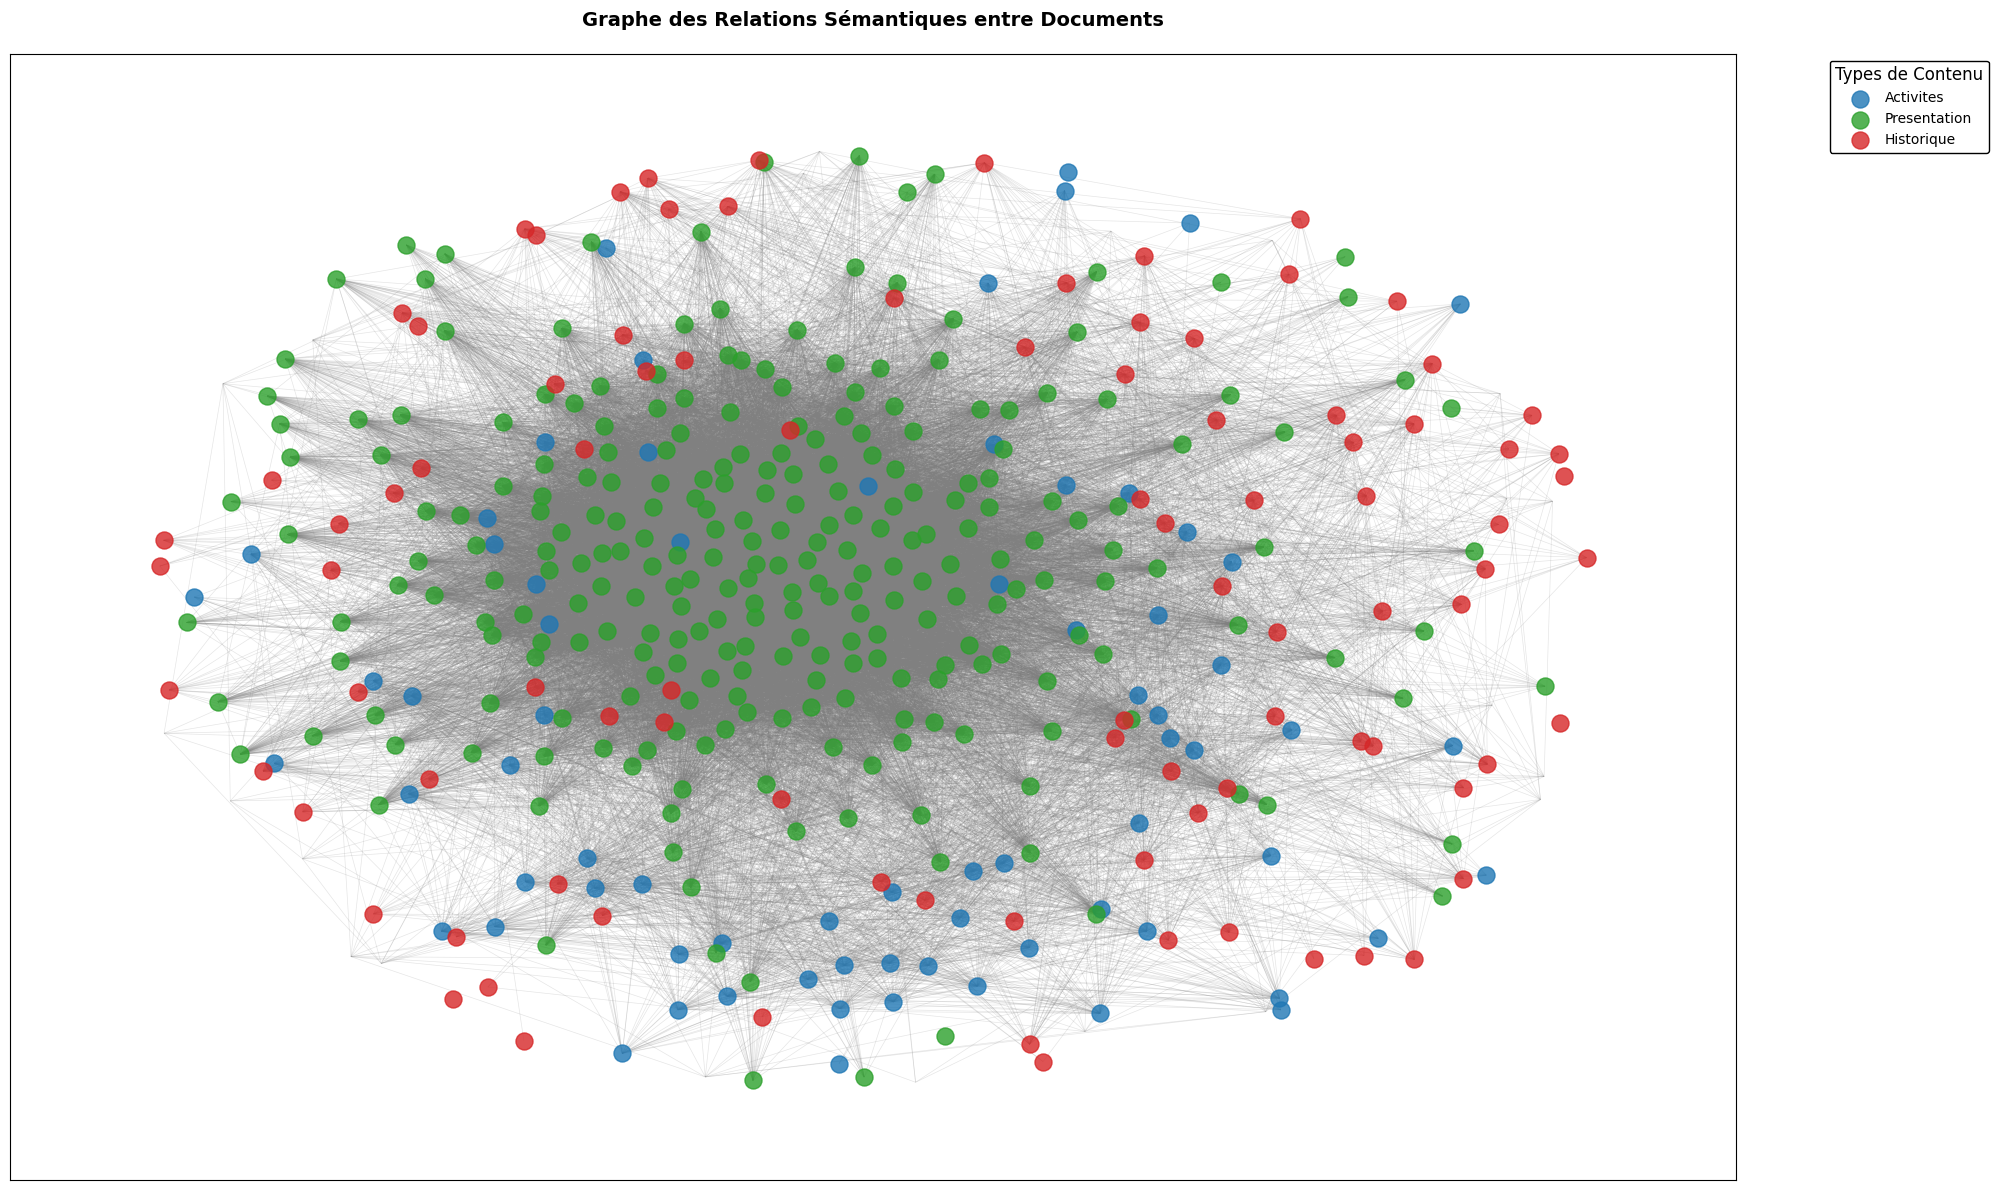

In [8]:
# Section 6 : Analyse des Relations Sémantiques améliorée
###########################################
# Création du graphe sémantique
G = nx.Graph()
embeddings = topic_model._extract_embeddings(processed_df['texte'].tolist())
similarities = cosine_similarity(embeddings)

# Ajouter les nœuds
for i in range(len(processed_df)):
    G.add_node(i, 
               space_name=processed_df['nom'].iloc[i],
               content_type=processed_df['type_texte'].iloc[i],
               topic=topics[i])

# Ajouter les arêtes
threshold = 0.3
for i in range(len(processed_df)):
    for j in range(i+1, len(processed_df)):
        if similarities[i,j] > threshold:
            if (processed_df['nom'].iloc[i] == processed_df['nom'].iloc[j] or 
                processed_df['type_texte'].iloc[i] == processed_df['type_texte'].iloc[j]):
                G.add_edge(i, j, weight=similarities[i,j])

# Configuration du style de la visualisation
plt.style.use('default')  # Reset du style
plt.figure(figsize=(20, 12), facecolor='white')
ax = plt.gca()
ax.set_facecolor('white')

# Couleurs distinctes et plus visibles
content_colors = {
    'activites': '#1f77b4',      # Bleu
    'presentation': '#2ca02c',    # Vert
    'historique': '#d62728',      # Rouge
    'reponse1': '#9467bd',       # Violet
    'reponse2': '#ff7f0e'        # Orange
}

# Calcul de la disposition du graphe
pos = nx.spring_layout(G, k=1, iterations=50)

# Dessiner les arêtes en premier avec une couleur claire
nx.draw_networkx_edges(G, pos, 
                      alpha=0.2, 
                      edge_color='grey',
                      width=0.5)

# Dessiner les nœuds avec des couleurs plus visibles
for content_type, color in content_colors.items():
    nodes = [n for n, attr in G.nodes(data=True) 
            if attr['content_type'] == content_type]
    if nodes:
        nx.draw_networkx_nodes(G, pos, 
                             nodelist=nodes,
                             node_color=color,
                             node_size=150,
                             alpha=0.8,
                             label=content_type.capitalize())

# Amélioration de la légende
plt.legend(bbox_to_anchor=(1.05, 1),
          loc='upper left',
          title='Types de Contenu',
          title_fontsize=12,
          fontsize=10,
          facecolor='white',
          edgecolor='black',
          framealpha=1)

# Titre et ajustements
plt.title("Graphe des Relations Sémantiques entre Documents",
          pad=20,
          fontsize=14,
          fontweight='bold')

# Ajustement des marges pour bien voir la légende
plt.tight_layout()
plt.savefig('graphe_semantique.png', 
            dpi=300,
            bbox_inches='tight',
            facecolor='white')
plt.show()


Exemple d'annotations générées :
Thème 0: artists & contemporary & artist
Thème 1: self & production & self production
Thème 2: Gallery & Gallery 44 & 44
Thème 3: Michele & Michele Michele & Deborah Bowmann
Thème 4: West & Front & West Space


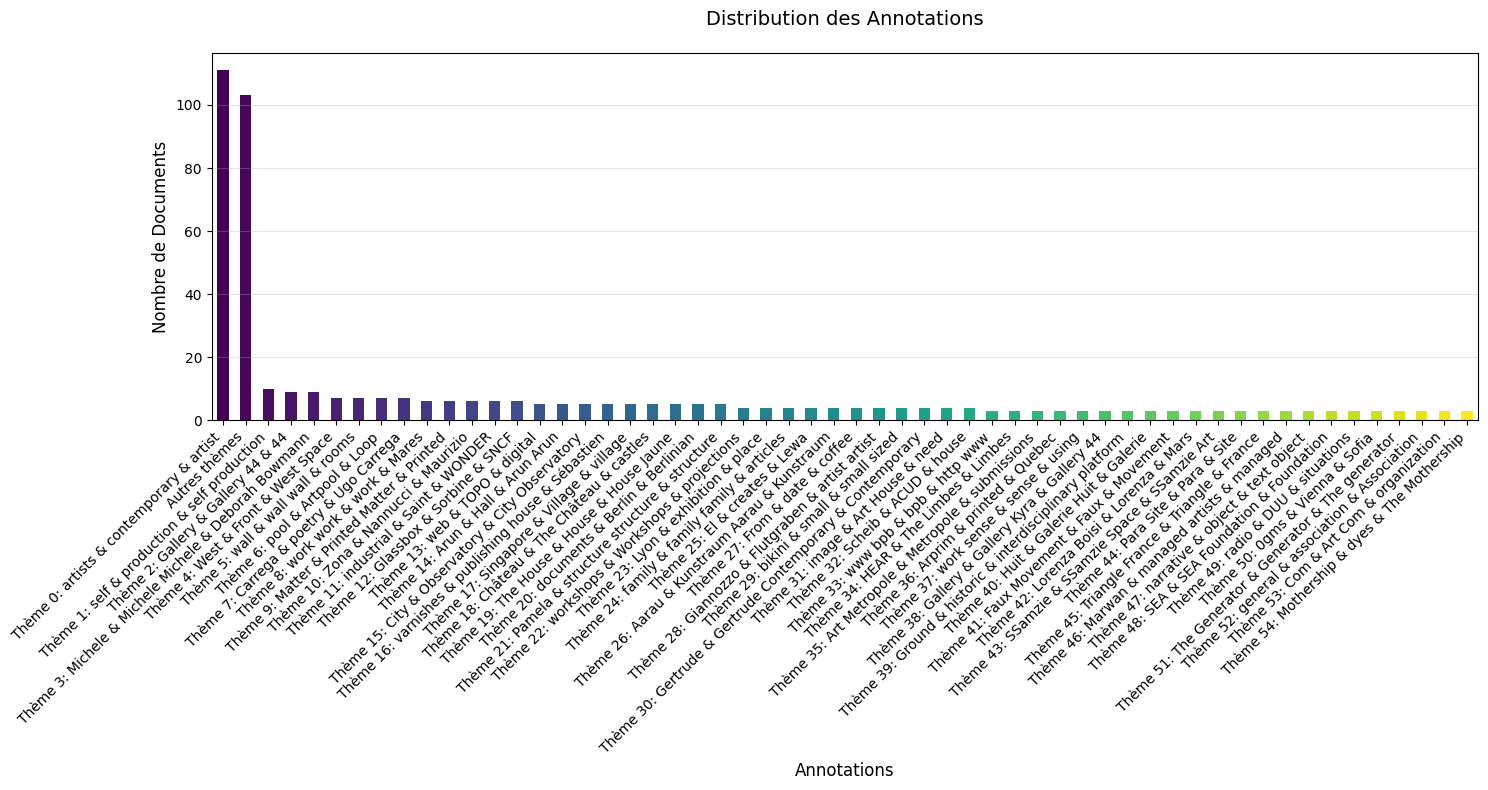

In [9]:
# Section 7 : Annotations et Pipeline
###########################################
def generate_topic_annotations(topic_model, topics):
    """
    Génère des annotations descriptives pour chaque topic
    """
    annotations = {}
    for topic_id in set(topics):
        if topic_id != -1:
            # Obtenir les mots-clés du topic
            keywords = topic_model.get_topic(topic_id)
            # Générer une annotation basée sur les mots-clés principaux
            main_keywords = [word for word, _ in keywords[:3]]
            annotation = " & ".join(main_keywords)
            annotations[topic_id] = f"Thème {topic_id}: {annotation}"
    
    # Ajouter une annotation pour le topic -1 (outliers)
    annotations[-1] = "Autres thèmes"
    return annotations

def topic_annotation_pipeline(new_texts, topic_model, existing_annotations=None):
    """
    Pipeline pour appliquer les annotations à de nouveaux textes
    
    Parameters:
    -----------
    new_texts : list
        Liste des nouveaux textes à analyser
    topic_model : BERTopic
        Modèle BERTopic entraîné
    existing_annotations : dict, optional
        Annotations existantes à réutiliser
        
    Returns:
    --------
    DataFrame avec les résultats de l'analyse
    """
    # Transformer les nouveaux textes
    new_topics, new_probs = topic_model.transform(new_texts)
    
    # Utiliser les annotations existantes ou en générer de nouvelles
    if existing_annotations is None:
        annotations = generate_topic_annotations(topic_model, new_topics)
    else:
        annotations = existing_annotations
    
    # Créer un DataFrame avec les résultats
    results = pd.DataFrame({
        'texte': new_texts,
        'topic': new_topics,
        'annotation': [annotations.get(topic, "Autre") for topic in new_topics],
        'probabilite': [np.max(prob) for prob in new_probs]
    })
    
    return results

# Application des annotations au DataFrame existant
topic_annotations = generate_topic_annotations(topic_model, topics)
processed_df['annotation'] = processed_df['topic'].map(topic_annotations)

# Affichage des résultats
print("\nExemple d'annotations générées :")
for topic_id, annotation in list(topic_annotations.items())[:5]:
    print(f"{annotation}")

# Visualisation de la distribution des annotations
plt.figure(figsize=(15, 8), facecolor='white')
annotation_counts = processed_df['annotation'].value_counts()
colors = plt.cm.viridis(np.linspace(0, 1, len(annotation_counts)))

annotation_counts.plot(kind='bar', color=colors)
plt.title("Distribution des Annotations", fontsize=14, pad=20)
plt.xlabel("Annotations", fontsize=12)
plt.ylabel("Nombre de Documents", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [43]:
# Section 8 : Export des Résultats Finaux
###########################################
# Sauvegarder les résultats enrichis
results_df = processed_df.copy()
results_df.to_excel("results_with_annotations.xlsx", index=False, engine='openpyxl')

# Afficher un résumé final
print("\nRésumé de l'analyse :")
print(f"Nombre total de documents : {len(results_df)}")
print(f"Nombre de topics identifiés : {len(topic_annotations)}")
print("\nAperçu des résultats finaux :")
display(results_df[['nom', 'type_texte', 'topic', 'annotation']].head())


Résumé de l'analyse :
Nombre total de documents : 455
Nombre de topics identifiés : 56

Aperçu des résultats finaux :


nom    type_texte  topic  \
0  Le Commissariat  presentation     -1   
1  Le Commissariat    historique     -1   
2             / 77     activites      0   
3             / 77  presentation     -1   
4        Immanence      réponse1     53   

                               annotation  
0                           Autres thèmes  
1                           Autres thèmes  
2          Thème 0: artists & space & art  
3                           Autres thèmes  
4  Thème 53: Art Com & Com & organization